# EEWS dengan Seisbench Models


## Import Libraries

In [ ]:
!pip install seisbench

In [ ]:
!pip install obspy

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

In [ ]:
import seisbench
import seisbench.util as sbu
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pathlib import Path

## Getting Data from OBSpy

In [ ]:
client = Client("GEOFON")

In [ ]:
def get_event_params(event):
    origin = event.preferred_origin()
    mag = event.preferred_magnitude()

    source_id = str(event.resource_id)

    event_params = {
        "source_id": source_id,
        "source_origin_time": str(origin.time),
        "source_origin_uncertainty_sec": origin.time_errors["uncertainty"],
        "source_latitude_deg": origin.latitude,
        "source_latitude_uncertainty_km": origin.latitude_errors["uncertainty"],
        "source_longitude_deg": origin.longitude,
        "source_longitude_uncertainty_km": origin.longitude_errors["uncertainty"],
        "source_depth_km": origin.depth / 1e3,
        # "source_depth_uncertainty_km": origin.depth_errors["uncertainty"] / 1e3,
    }

    if mag is not None:
        event_params["source_magnitude"] = mag.mag
        event_params["source_magnitude_uncertainty"] = mag.mag_errors["uncertainty"]
        event_params["source_magnitude_type"] = mag.magnitude_type
        event_params["source_magnitude_author"] = mag.creation_info.agency_id

        # if str(origin.time) < "2015-01-07":
        #     split = "train"
        # elif str(origin.time) < "2015-01-08":
        #     split = "dev"
        # else:
        #     split = "test"
        # event_params["split"] = split

    return event_params

In [ ]:
def get_trace_params(pick):
    net = pick.waveform_id.network_code
    sta = pick.waveform_id.station_code

    trace_params = {
        "station_network_code": net,
        "station_code": sta,
        "trace_channel": pick.waveform_id.channel_code[:2],
        "station_location_code": pick.waveform_id.location_code,
    }

    return trace_params

In [ ]:
def get_waveforms(pick, trace_params, time_before=60, time_after=600):
    t_start = pick.time - time_before
    t_end = pick.time + time_after

    try:
        waveforms = client.get_waveforms(
            network=trace_params["station_network_code"],
            station=trace_params["station_code"],
            location="*",
            channel="BH*",
            starttime=t_start,
            endtime=t_end,
        )
    except FDSNException:
        # Return empty stream
        waveforms = obspy.Stream()

    return waveforms

In [ ]:
base_path = Path(".")
metadata_path = base_path / "metadata.csv"
waveforms_path = base_path / "waveforms.hdf5"

In [ ]:
def get_data_from_obspy(start_time, n_day, min, max):
  t0 = start_time
  t1 = t0 + n_day
  min_latitude = -11.0
  max_latitude = 6.0
  min_longitude = 95.0
  max_longitude = 141.0
  catalog = client.get_events(t0, t1, minlatitude=min_latitude, maxlatitude=max_latitude, minlongitude=min_longitude, maxlongitude=max_longitude, minmagnitude=min, maxmagnitude=max, mindepth=50, includearrivals=True)
  return catalog

In [ ]:
# all_streams_catalog = []
# all_trace_params_catalog = []
# with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:

#     # Define data format
#     writer.data_format = {
#         "dimension_order": "CW",
#         "component_order": "ZNE",
#         "measurement": "velocity",
#         "unit": "counts",
#         "instrument_response": "not restituted",
#     }
#     for i in range(10):
#       start_time = UTCDateTime(2018, 1, 1) + i * 100 * 24 * 60 * 60
#       n_day = 100 * 24 * 60 * 60
#       catalog = get_data_from_obspy(start_time, n_day)
#       stream_catalog = [[] for _ in catalog]
#       trace_params_catalog = [[] for _ in catalog]

#       event_counter = 0
#       for event in catalog:
#           temp_s_pick = None
#           temp_p_pick = None
#           for pick in event.picks:
#             if pick.phase_hint == 'S':
#               temp_s_pick = pick
#               break
#           for pick in event.picks:
#             if temp_s_pick is not None and pick.waveform_id.station_code == temp_s_pick.waveform_id.station_code and pick.phase_hint == 'P':
#               temp_p_pick = pick
#               # print(temp_s_pick)
#               # print(temp_p_pick)
#               break
#           if temp_s_pick is None or temp_p_pick is None:
#             continue
#           else:
#             # Initialize the inner list for each event
#             stream_catalog[event_counter] = []
#             pick_catalog = [temp_p_pick,temp_s_pick]
#             event_params = get_event_params(event)
#             for pick in pick_catalog:
#                 if pick.waveform_id.station_code not in ["BKB", "BKNI","BBJI","BNDI", "CISI", "FAKI", "GENI", "GSI","JAGI",
#                                                         "LHMI", "LUWI", "MMRI", "MNAI", "PLAI", "PMBT","PMBI", "SANI",
#                                                         "SAUI","SMRI","SOEI","TNTI","TOLI","TOLI2", "UGM", "YOGI"
#                                                         ]:
#                   continue
#                 else:
#                   stream = get_waveforms(pick, get_trace_params(pick))
#                   trace_params = get_trace_params(pick)

#                   if len(stream) == 0:
#                       # No waveform data available
#                       continue

#                   sampling_rate = stream[0].stats.sampling_rate

#                   try:
#                     # Check that the traces have the same sampling rate
#                     assert all(trace.stats.sampling_rate == sampling_rate for trace in stream)
#                     actual_t_start, data, _ = sbu.stream_to_array(
#                         stream,
#                         component_order=writer.data_format["component_order"],
#                     )

#                     trace_params["trace_sampling_rate_hz"] = sampling_rate
#                     trace_params["trace_start_time"] = str(actual_t_start)
#                     trace_params[f"trace_{pick.phase_hint}_arrival_time"] = str(pick.time)
#                     sample = (pick.time - actual_t_start) * sampling_rate
#                     trace_params[f"trace_{pick.phase_hint}_arrival_sample"] = int(sample)
#                     trace_params[f"trace_{pick.phase_hint}_status"] = pick.evaluation_mode
#                     trace_params_catalog[event_counter].append(trace_params)
#                     stream_catalog[event_counter].append(stream)
#                     writer.add_trace({**event_params, **trace_params}, data)
#                   except:
#                     print("error")
#           event_counter += 1
#       for stream in stream_catalog:
#         if len(stream) != 0:
#           all_streams_catalog.append(stream)

#       for trace in trace_params_catalog:
#         if len(trace) != 0:
#           all_trace_params_catalog.append(trace)

#       print(len(all_streams_catalog))
#       print(len(all_trace_params_catalog))


In [ ]:
all_streams_catalog = []
all_trace_params_catalog = []


low_magnitude_catalog = [] #3-4 - 50 / 25s
mid_magnitude_catalog = [] #4-6 - 100 / 50s
high_magnitude_catalog = [] #6+ - 50 / 25s
s_phase_index = []
def get_data(min, max, quantity, s_flag):
    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    magnitude_catalog = []
    magnitude_param_catalog = []
    selected_event_catalog = []
    event_params = []
    break_flag = False

    for i in range(307):
        start_time = UTCDateTime(2016, 1, 1) + i * 10 * 24 * 60 * 60
        n_day = 10 * 24 * 60 * 60
        catalog = []
        try:
            catalog = get_data_from_obspy(start_time, n_day, min, max)
        except:
            continue
        stream_catalog = [[] for _ in catalog]
        trace_params_catalog = [[] for _ in catalog]
        event_counter = 0
        event_flag = False
        for event in catalog:
            if s_flag:
                temp_s_pick = None
                for pick in event.picks:
                    if pick.phase_hint == 'S':
                        temp_s_pick = pick
                        break
                if temp_s_pick is None:
                    continue
            else:
                temp_s_pick = None
                for pick in event.picks:
                    if pick.phase_hint == 'S':
                        temp_s_pick = pick
                        break
                if temp_s_pick is not None:
                    continue
            if len(magnitude_catalog) >= quantity:
                break_flag = True
                break
            else:
                for pick in event.picks:
                    if pick.waveform_id.station_code not in [
                        "BKB", "BKNI", "BBJI", "BNDI", "CISI", "FAKI", "GENI", "GSI", "JAGI",
                        "LHMI", "LUWI", "MMRI", "MNAI", "PLAI", "PMBT", "PMBI", "SANI",
                        "SAUI", "SMRI", "SOEI", "TNTI", "TOLI", "TOLI2", "UGM", "YOGI"
                    ]:
                        continue
                    try:
                        stream = get_waveforms(pick, get_trace_params(pick))
                    except:
                        print("error")
                        continue
                    trace_params = get_trace_params(pick)

                    if len(stream) == 0:
                        print(True)
                        continue

                    sampling_rate = stream[0].stats.sampling_rate

                    try:
                        assert all(trace.stats.sampling_rate == sampling_rate for trace in stream)
                        actual_t_start, data, _ = sbu.stream_to_array(
                            stream,
                            component_order="ZNE",
                        )

                        trace_params["trace_sampling_rate_hz"] = sampling_rate
                        trace_params["trace_start_time"] = str(actual_t_start)
                        trace_params[f"trace_{pick.phase_hint}_arrival_time"] = str(pick.time)
                        sample = (pick.time - actual_t_start) * sampling_rate
                        trace_params[f"trace_{pick.phase_hint}_arrival_sample"] = int(sample)
                        trace_params[f"trace_{pick.phase_hint}_status"] = pick.evaluation_mode

                        trace_params_catalog[event_counter].append(trace_params)
                        stream_catalog[event_counter].append(stream)
                        event_flag = True
                    except:
                        print("error")

                if len(magnitude_catalog) < quantity and event_flag:
                    magnitude_catalog.append(stream_catalog[event_counter])
                    magnitude_param_catalog.append(trace_params_catalog[event_counter])
                    selected_event_catalog.append(event)
                    event_params.append(get_event_params(event))
                if event_flag:
                    event_counter += 1
                event_flag = False

        if break_flag:
            break

        return magnitude_catalog, magnitude_param_catalog, selected_event_catalog, event_params

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

def save_catalogs_to_drive(catalogs, filename):
    # Path to save the file in Google Drive
    filepath = f'/content/drive/My Drive/{filename}.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(catalogs, f)
    print(f'Saved to {filepath}')

def load_catalogs_from_drive(filename):
    # Path to load the file from Google Drive
    filepath = f'/content/drive/My Drive/EEWS/{filename}.pkl'
    with open(filepath, 'rb') as f:
        catalogs = pickle.load(f)
    return catalogs


In [ ]:
# Save the catalogs to Google Drive
save_catalogs_to_drive((low_magnitude_catalog, low_param_catalog, selected_low_event_catalog), 'low_magnitude_catalogs')
save_catalogs_to_drive((mid_magnitude_catalog, mid_param_catalog, selected_mid_magnitude_event_catalog), 'mid_magnitude_catalogs')
save_catalogs_to_drive((high_magnitude_catalog, high_param_catalog, selected_high_magnitude_event_catalog), 'high_magnitude_catalogs')
save_catalogs_to_drive((low_magnitude_s_phase_catalog, low_param_s_phase_catalog, selected_low_magnitude_s_event_catalog), 'low_magnitude_s_phase_catalogs')
save_catalogs_to_drive((mid_magnitude_s_phase_catalog, mid_param_s_phase_catalog, selected_mid_magnitude_s_event_catalog), 'mid_magnitude_s_phase_catalogs')
save_catalogs_to_drive((high_magnitude_s_phase_catalog, high_param_s_phase_catalog, selected_high_magnitude_s_event_catalog), 'high_magnitude_s_phase_catalogs')

print("All catalogs have been saved to Google Drive.")

In [ ]:
# Load the catalogs
low_magnitude_catalogs = load_catalogs_from_drive('low_magnitude_catalogs')
mid_magnitude_catalogs = load_catalogs_from_drive('mid_magnitude_catalogs')
high_magnitude_catalogs = load_catalogs_from_drive('high_magnitude_catalogs')
low_magnitude_s_phase_catalogs = load_catalogs_from_drive('low_magnitude_s_phase_catalogs')
mid_magnitude_s_phase_catalogs = load_catalogs_from_drive('mid_magnitude_s_phase_catalogs')
high_magnitude_s_phase_catalogs = load_catalogs_from_drive('high_magnitude_s_phase_catalogs')

# Unpack the loaded catalogs into separate variables
low_magnitude_catalog, low_param_catalog, selected_low_event_catalog, low_event_params = low_magnitude_catalogs
mid_magnitude_catalog, mid_param_catalog, selected_mid_magnitude_event_catalog, mid_event_params = mid_magnitude_catalogs
high_magnitude_catalog, high_param_catalog, selected_high_magnitude_event_catalog, high_event_params = high_magnitude_catalogs
low_magnitude_s_phase_catalog, low_param_s_phase_catalog, selected_low_magnitude_s_event_catalog, low_s_event_params = low_magnitude_s_phase_catalogs
mid_magnitude_s_phase_catalog, mid_param_s_phase_catalog, selected_mid_magnitude_s_event_catalog, mid_s_event_params = mid_magnitude_s_phase_catalogs
high_magnitude_s_phase_catalog, high_param_s_phase_catalog, selected_high_magnitude_s_event_catalog, high_s_event_params = high_magnitude_s_phase_catalogs

# Combine the catalogs
combined_low_magnitude_catalog = low_magnitude_catalog + low_magnitude_s_phase_catalog
combined_low_param_catalog = low_param_catalog + low_param_s_phase_catalog
combined_selected_low_event_catalog = selected_low_event_catalog + selected_low_magnitude_s_event_catalog
combined_low_event_params = low_event_params + low_s_event_params

combined_mid_magnitude_catalog = mid_magnitude_catalog + mid_magnitude_s_phase_catalog
combined_mid_param_catalog = mid_param_catalog + mid_param_s_phase_catalog
combined_selected_mid_event_catalog = selected_mid_magnitude_event_catalog + selected_mid_magnitude_s_event_catalog
combined_mid_event_params = mid_event_params + mid_s_event_params

combined_high_magnitude_catalog = high_magnitude_catalog + high_magnitude_s_phase_catalog
combined_high_param_catalog = high_param_catalog + high_param_s_phase_catalog
combined_selected_high_event_catalog = selected_high_magnitude_event_catalog + selected_high_magnitude_s_event_catalog
combined_high_event_params = high_event_params + high_s_event_params



In [ ]:
def resample_catalog(catalog, new_sampling_rate):
    for event in catalog:
        for pick in event:
            for trace in pick:
                if trace.stats.sampling_rate != new_sampling_rate:
                    trace.resample(sampling_rate=new_sampling_rate)
            # pick.normalize(global_max=True)

In [ ]:
import copy

# Make copies of the combined catalogs
combined_low_magnitude_catalog_copy = copy.deepcopy(combined_low_magnitude_catalog)
combined_mid_magnitude_catalog_copy = copy.deepcopy(combined_mid_magnitude_catalog)
combined_high_magnitude_catalog_copy = copy.deepcopy(combined_high_magnitude_catalog)

# Desired new sampling rate
new_sampling_rate = 100.0

# Resample the copied catalogs
resample_catalog(combined_low_magnitude_catalog_copy, new_sampling_rate)
resample_catalog(combined_mid_magnitude_catalog_copy, new_sampling_rate)
resample_catalog(combined_high_magnitude_catalog_copy, new_sampling_rate)

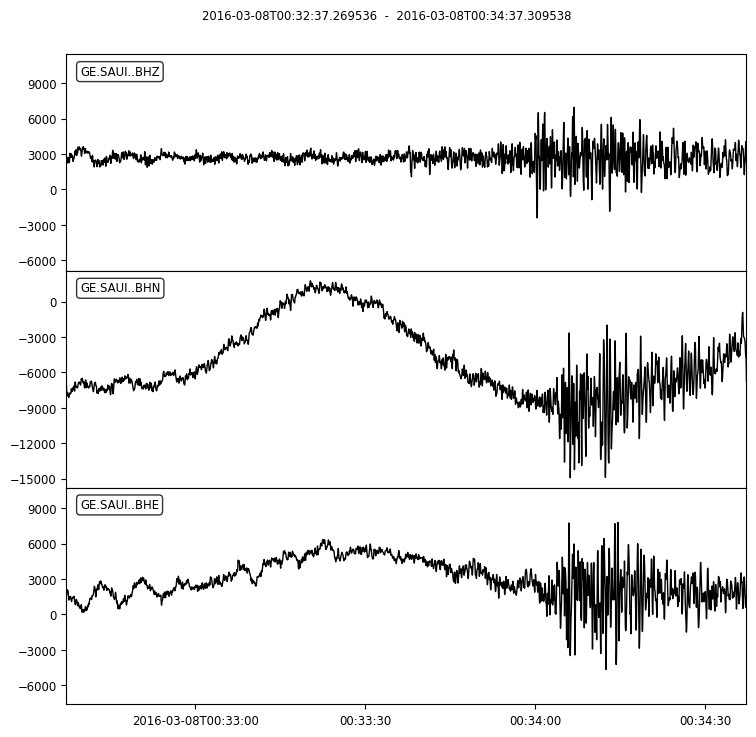

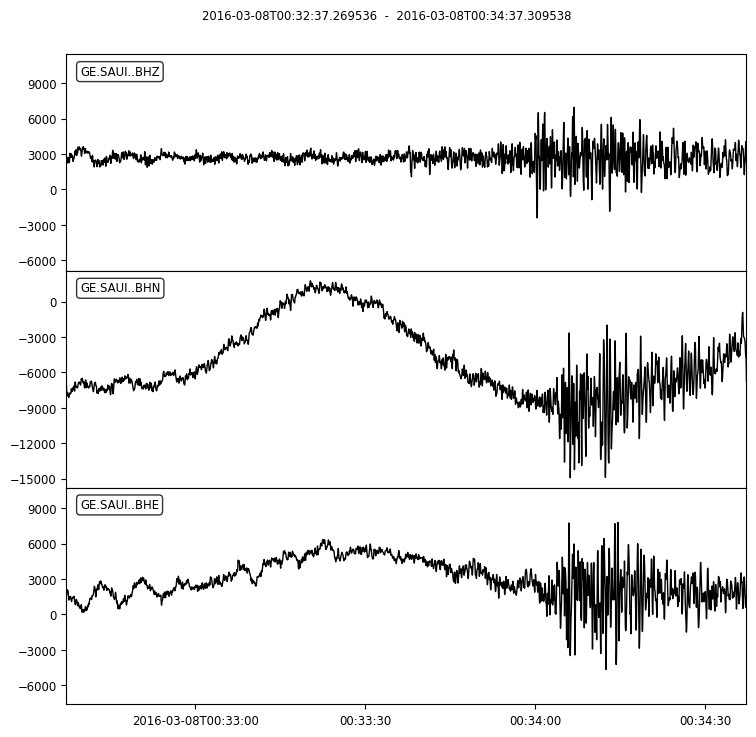

In [ ]:
combined_low_magnitude_catalog_copy[0][0].plot()


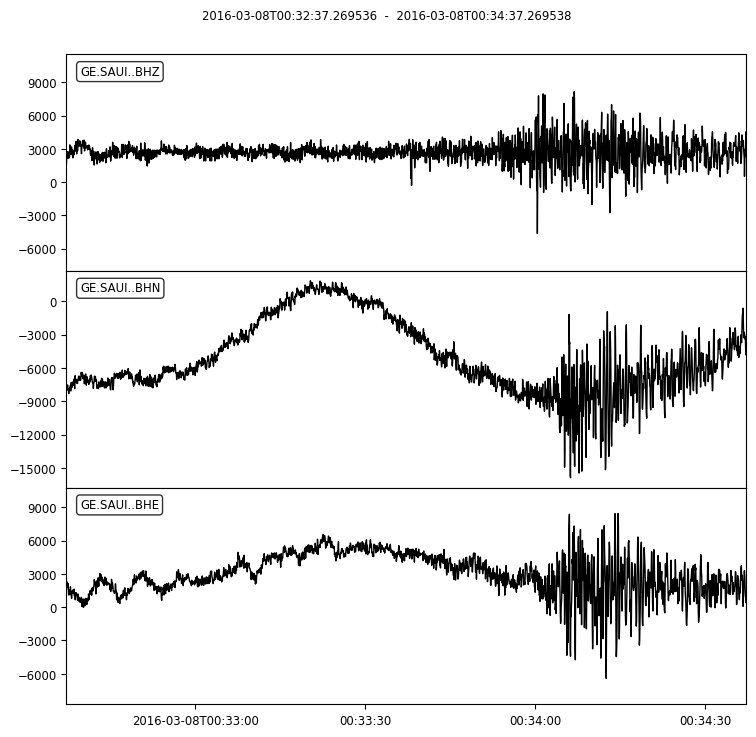

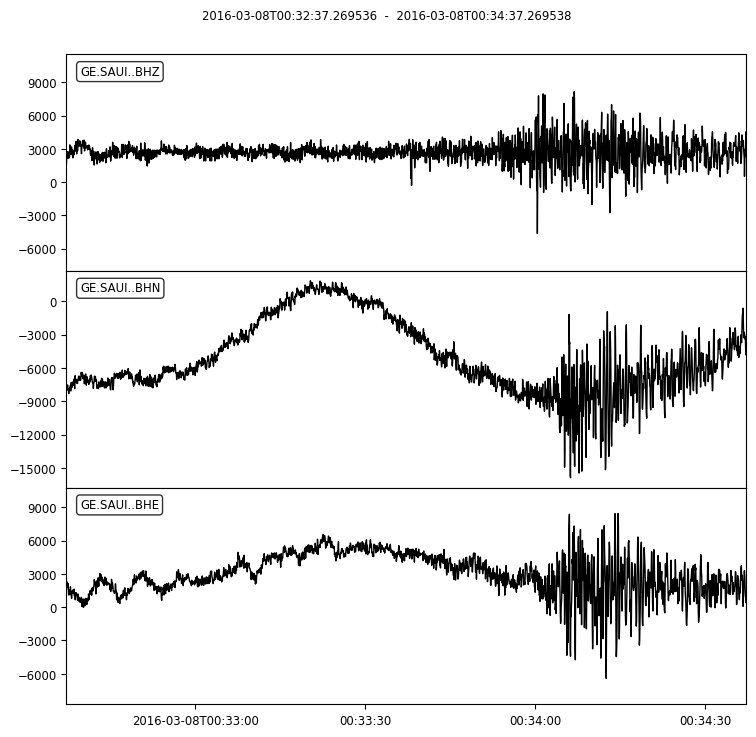

In [ ]:
combined_low_magnitude_catalog[0][0].plot()

In [ ]:
print(combined_high_event_params[0])

{'source_id': 'smi:org.gfz-potsdam.de/geofon/gfz2016lagz', 'source_origin_time': '2016-06-05T16:25:34.590000Z', 'source_origin_uncertainty_sec': 0.09, 'source_latitude_deg': -4.595, 'source_latitude_uncertainty_km': 1.2, 'source_longitude_deg': 125.651, 'source_longitude_uncertainty_km': 1.03, 'source_depth_km': 448.6, 'source_magnitude': 6.28, 'source_magnitude_uncertainty': None, 'source_magnitude_type': 'Mw', 'source_magnitude_author': 'GFZ', 'split': 'test'}


In [ ]:
print(combined_high_magnitude_catalog[0][0])

3 Trace(s) in Stream:
GE.SANI..BHN | 2016-06-05T16:25:38.369538Z - 2016-06-05T16:27:38.369538Z | 20.0 Hz, 2401 samples
GE.SANI..BHE | 2016-06-05T16:25:38.369538Z - 2016-06-05T16:27:38.369538Z | 20.0 Hz, 2401 samples
GE.SANI..BHZ | 2016-06-05T16:25:38.369538Z - 2016-06-05T16:27:38.369538Z | 20.0 Hz, 2401 samples


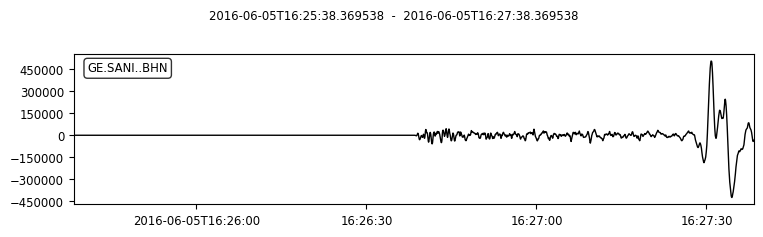

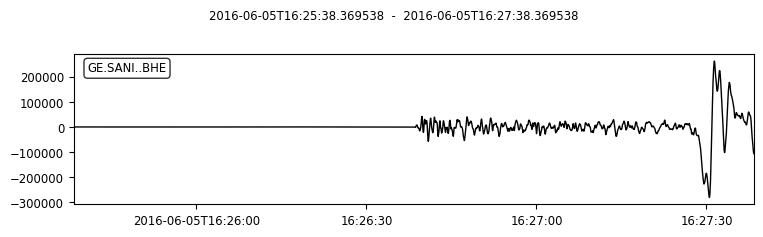

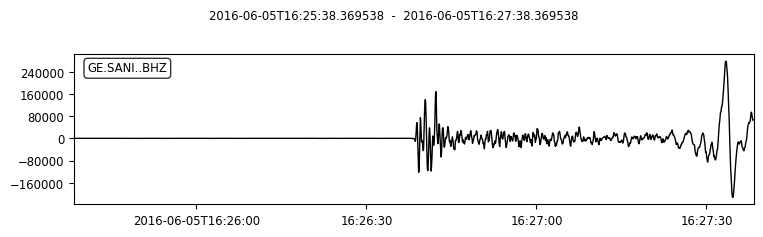

In [ ]:
for i in combined_high_magnitude_catalog[0][0]:
    i.plot()

### Models Used

In [ ]:
pretrained_weights = sbm.DeepDenoiser.list_pretrained(details=True)
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

In [ ]:
pretrained_weights = sbm.PhaseNet.list_pretrained(details=True)
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

In [ ]:
pretrained_weights = sbm.EQTransformer.list_pretrained(details=True)
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

In [ ]:
pretrained_weights = sbm.GPD.list_pretrained(details=True)
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

In [ ]:
model_denoiser = sbm.DeepDenoiser.from_pretrained("original")
model_phasenet = sbm.PhaseNet.from_pretrained("original")
model_eqtransformer = sbm.EQTransformer.from_pretrained("original")

Downloading: 100%|██████████| 5.31M/5.31M [00:01<00:00, 3.95MB/s]
Downloading: 100%|██████████| 1.06M/1.06M [00:00<00:00, 1.37MB/s]
Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 1.73MB/s]


### Preprocessing

#### Denoising Waveform Data

In [ ]:
import time
def denoised_catalog(catalog):
    denoised_catalog = [[] for _ in catalog]

    event_counter = 0
    iteration_times = []  # List to store the time taken for each iteration
    for event in catalog:
        start_time = time.time()
        # Initialize the inner list for each event
        denoised_catalog[event_counter] = []
        for pick in event:
            denoised = model_denoiser.annotate(pick)
            # Append the denoised pick to the current event's list
            denoised_catalog[event_counter].append(denoised)
        event_counter += 1
        end_time = time.time()  # Record the end time for the iteration
        iteration_time = end_time - start_time  # Calculate the time taken for the iteration
        iteration_times.append(iteration_time)  # Store the iteration time
    return denoised_catalog, iteration_times



In [ ]:
start_time = time.time()
low_denoised, time_denoiser_low = denoised_catalog(combined_low_magnitude_catalog_copy)
mid_denoised, time_denoiser_mid = denoised_catalog(combined_mid_magnitude_catalog_copy)
high_denoised, time_denoiser_high = denoised_catalog(combined_high_magnitude_catalog_copy)
end_time = time.time()
total_time_denoiser = end_time - start_time
print(f"Completed DeepDenoiser predictions for denoised data. Total time taken: {total_time_denoiser:.2f} seconds")

mean_low_denoiser = np.mean(time_denoiser_low)
mean_mid_denoiser = np.mean(time_denoiser_mid)
mean_high_denoiser = np.mean(time_denoiser_high)
print("Mean iteration times for DeepDenoiser low denoised data:", mean_low_denoiser)
print("Mean iteration times for DeepDenoiser mid denoised data:", mean_mid_denoiser)
print("Mean iteration times for DeepDenoiser high denoised data:", mean_high_denoiser)

Completed DeepDenoiser predictions for denoised data. Total time taken: 351.14 seconds
Mean iteration times for DeepDenoiser low denoised data: 0.8785091014135451
Mean iteration times for DeepDenoiser mid denoised data: 1.386459994862098
Mean iteration times for DeepDenoiser high denoised data: 3.147095521291097


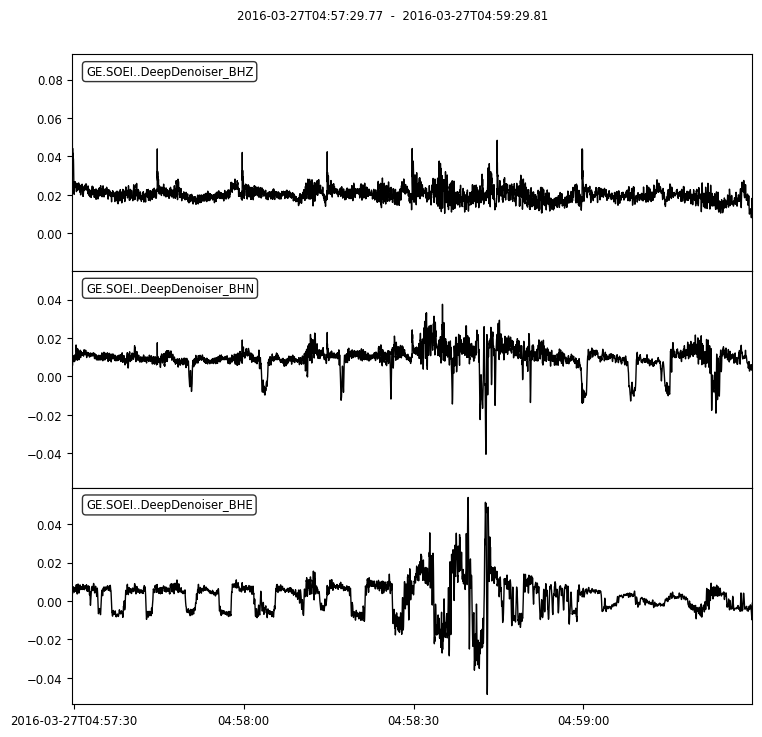

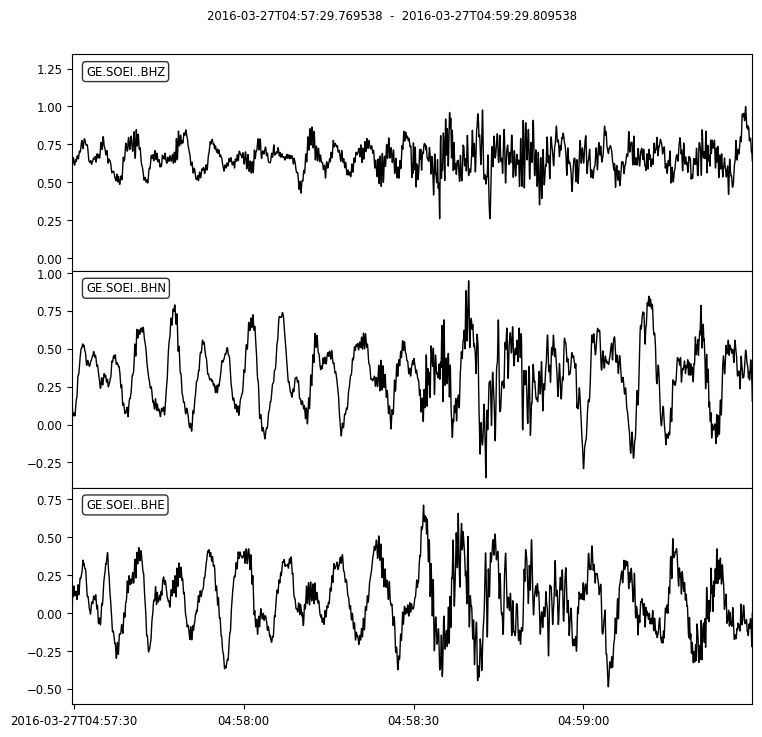

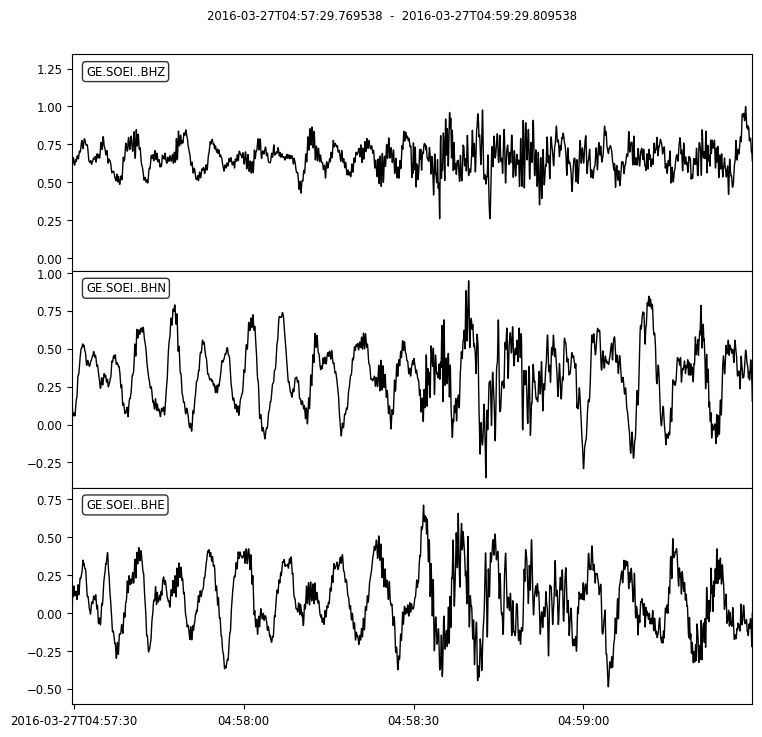

In [ ]:
low_denoised[1][0].plot()
combined_low_magnitude_catalog_copy[1][0].plot()

In [ ]:
def tag_picks(picks):
    # Create a dictionary to store the tags for each pick
    tagged_picks = []

    # Iterate over the picks to tag them
    for pick in picks:
        if 'trace_P_arrival_sample' in pick:
            pick['phase'] = 'P'
        elif 'trace_S_arrival_sample' in pick:
            pick['phase'] = 'S'
        else:
            print(pick)
            pick['phase'] = 'Unknown'

        tagged_picks.append(pick)
    # Search for matching P and S phases from the same station
    for pick in tagged_picks:
        if pick['phase'] == 'S':
            station = pick['station_code']
            # Look for a matching P phase from the same station
            for other_pick in tagged_picks:
                if other_pick['station_code'] == station and other_pick['phase'] == 'P':
                    pick['phase'] = 'P and S'
                    other_pick['phase'] = 'P and S'
                    break

    return tagged_picks

In [ ]:
def get_phase(catalog):
    tagged_pick_event = []
    for picks in catalog:
        tagged_pick_event.append(tag_picks(picks))
    return tagged_pick_event

In [ ]:
# print(combined_low_param_catalog)
tagged_low = get_phase(combined_low_param_catalog)
tagged_mid = get_phase(combined_mid_param_catalog)
tagged_high = get_phase(combined_high_param_catalog)

{'station_network_code': 'GE', 'station_code': 'MNAI', 'trace_channel': 'BH', 'station_location_code': None, 'trace_sampling_rate_hz': 20.0, 'trace_start_time': '2023-11-17T08:18:39.819538Z', 'trace_pP_arrival_time': '2023-11-17T08:19:39.810000Z', 'trace_pP_arrival_sample': 1199, 'trace_pP_status': 'manual'}
{'station_network_code': 'GE', 'station_code': 'MNAI', 'trace_channel': 'BH', 'station_location_code': None, 'trace_sampling_rate_hz': 20.0, 'trace_start_time': '2023-05-24T15:54:54.169538Z', 'trace_sP_arrival_time': '2023-05-24T15:55:54.190000Z', 'trace_sP_arrival_sample': 1200, 'trace_sP_status': 'manual'}
{'station_network_code': 'GE', 'station_code': 'LHMI', 'trace_channel': 'BH', 'station_location_code': None, 'trace_sampling_rate_hz': 20.0, 'trace_start_time': '2023-08-28T20:01:20.519538Z', 'trace_sP_arrival_time': '2023-08-28T20:02:20.500000Z', 'trace_sP_arrival_sample': 1199, 'trace_sP_status': 'manual'}
{'station_network_code': 'GE', 'station_code': 'GSI', 'trace_channel':

### Model Prediction

####Clasification Evaluation


In [ ]:
def extract_station_phase_info(classify_catalog):
    """
    Extracts station and phase information from the classify catalog.
    """
    station_phase_info = []
    for event in classify_catalog:
        for pick in event.picks:
            station_phase_info.append({
                'station_code': pick.trace_id.split('.')[1],  # Extract station code from trace_id
                'start_time': pick.start_time,
                'phase': pick.phase
            })
    return station_phase_info


def remove_duplicates(picks, ground_truth_event):
    """
    Removes duplicates from the list of picks based on station_code and phase.
    Keeps the pick closest to the ground truth arrival time if provided.
    """
    seen = {}
    unique_picks = []

    ground_truth_p_times = {gt['station_code']: UTCDateTime(gt['trace_P_arrival_time']) for gt in ground_truth_event if 'trace_P_arrival_time' in gt}
    ground_truth_s_times = {gt['station_code']: UTCDateTime(gt['trace_S_arrival_time']) for gt in ground_truth_event if 'trace_S_arrival_time' in gt}
    # print(ground_truth_p_times)
    for pick in picks:
        identifier = (pick['station_code'], pick['phase'])
        if identifier not in seen:
            seen[identifier] = pick
        else:
            existing_pick = seen[identifier]
            ground_truth_time = ground_truth_p_times.get(pick['station_code']) if pick['phase'] == 'P' else ground_truth_s_times.get(pick['station_code'])
            if ground_truth_time:
                # Compare distance to ground truth time
                if abs(pick['start_time'] - ground_truth_time) < abs(existing_pick['start_time'] - ground_truth_time):
                    seen[identifier] = pick
            else:
                # If no ground truth time is available, keep the existing pick
                continue

    for identifier, pick in seen.items():
        unique_picks.append(pick)

    return unique_picks



def evaluate_predictions(predicted_catalog, ground_truth_catalog):
    """
    Evaluate the model's predictions against ground truth.
    """
    TP = 0
    FP = 0
    FN = 0

    total_ground_truth_picks = 0

    for predicted_phases, ground_truth_event in zip(predicted_catalog, ground_truth_catalog):
        predicted_phases_set = {(pick['station_code'], pick['phase']) for pick in predicted_phases}
        ground_truth_phases_set = {(pick['station_code'], pick['phase']) for pick in ground_truth_event}

        # Check true positives, false negatives, and false positives
        for phase_info in ground_truth_phases_set:
            station, true_phase = phase_info
            predicted_phases_for_station = {pred_phase for (pred_station, pred_phase) in predicted_phases_set if pred_station == station}
            if true_phase == 'P':
                total_ground_truth_picks+=1
                if 'P' in predicted_phases_for_station:
                    TP += 1
                if 'S' in predicted_phases_for_station:
                    FP += 1  # Count extra S as a false positive
                    FN += 1  # Count missing P as a false negative
                if 'P' not in predicted_phases_for_station and 'S' not in predicted_phases_for_station:
                    FN += 1

            elif true_phase == 'S':
                total_ground_truth_picks+=1
                if 'P' in predicted_phases_for_station:
                    FP += 1  # Count incorrect P as a false positive
                    FN += 1  # Count missing S as a false negative

                elif 'S' in predicted_phases_for_station:
                    TP += 1
                else:
                    FN += 1

            elif true_phase == 'P and S':
                total_ground_truth_picks+=2
                if 'P' in predicted_phases_for_station and 'S' in predicted_phases_for_station:
                    TP += 2  # Both P and S are correct
                elif 'P' in predicted_phases_for_station:
                    TP += 1
                    FN += 1  # Missing S
                elif 'S' in predicted_phases_for_station:
                    TP += 1
                    FN += 1  # Missing P
                else:
                    FN += 2  # Both P and S are missing
            else:
                continue

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = TP / total_ground_truth_picks if total_ground_truth_picks > 0 else 0

    return {'TP': TP, 'FP': FP, 'FN': FN, 'Precision': precision, 'Recall': recall, 'F1_Score': f1_score, 'Accuracy': accuracy}

In [ ]:

def model_predict_hyperparameter(model, catalog, ground_truth):
    p_thres_options = [0.3, 0.25, 0.2, 0.1, 0.05]
    s_thres_options = [0.3, 0.25, 0.2, 0.1, 0.05]

    best_performance = None
    best_p_thres = None
    best_s_thres = None

    for P_thres in p_thres_options:
        for S_thres in s_thres_options:
            model_catalog = [[] for _ in catalog]
            model_classify_catalog = [[] for _ in catalog]
            event_counter = 0
            for event in catalog:
                # Initialize the inner list for each event
                model_catalog[event_counter] = []
                for pick in event:
                    phase = model.annotate(pick)
                    model_classify = model.classify(pick, P_threshold=P_thres, S_threshold=S_thres)
                    model_catalog[event_counter].append(phase)
                    model_classify_catalog[event_counter].append(model_classify)
                event_counter += 1

            phase_info = [extract_station_phase_info(event) for event in model_classify_catalog]
            performance = evaluate_predictions(phase_info, ground_truth)

            if best_performance is None or performance['F1_Score'] > best_performance['F1_Score']:
                best_performance = performance
                best_p_thres = P_thres
                best_s_thres = S_thres

    return best_p_thres, best_s_thres, best_performance

In [ ]:

# Tuning and evaluating for low denoised data
print("Tuning and evaluating for low denoised data")
best_p_thres_low, best_s_thres_not_low, evaluation_low = model_predict_hyperparameter(model_phasenet, low_denoised, tagged_low)
print(f'Best P_thres (low): {best_p_thres_low}, Best S_thres_not (low): {best_s_thres_not_low}, Performance (low): {evaluation_low}')

# Tuning and evaluating for mid denoised data
print("Tuning and evaluating for mid denoised data")
best_p_thres_mid, best_s_thres_not_mid, evaluation_mid = model_predict_hyperparameter(model_phasenet, mid_denoised, tagged_mid)
print(f'Best P_thres (mid): {best_p_thres_mid}, Best S_thres_not (mid): {best_s_thres_not_mid}, Performance (mid): {evaluation_mid}')

# Tuning and evaluating for high denoised data
print("Tuning and evaluating for high denoised data")
best_p_thres_high, best_s_thres_not_high, evaluation_high = model_predict_hyperparameter(model_phasenet, high_denoised, tagged_high)
print(f'Best P_thres (high): {best_p_thres_high}, Best S_thres_not (high): {best_s_thres_not_high}, Performance (high): {evaluation_high}')


Tuning and evaluating for low denoised data
Best P_thres (low): 0.05, Best S_thres_not (low): 0.3, Performance (low): {'TP': 91, 'FP': 29, 'FN': 35, 'Precision': 0.7583333333333333, 'Recall': 0.7222222222222222, 'F1_Score': 0.7398373983739837, 'Accuracy': 0.9381443298969072}
Tuning and evaluating for mid denoised data
Best P_thres (mid): 0.05, Best S_thres_not (mid): 0.3, Performance (mid): {'TP': 904, 'FP': 194, 'FN': 237, 'Precision': 0.8233151183970856, 'Recall': 0.7922874671340929, 'F1_Score': 0.8075033497096917, 'Accuracy': 0.9485834207764953}
Tuning and evaluating for high denoised data
Best P_thres (high): 0.05, Best S_thres_not (high): 0.3, Performance (high): {'TP': 827, 'FP': 205, 'FN': 213, 'Precision': 0.8013565891472868, 'Recall': 0.7951923076923076, 'F1_Score': 0.7982625482625482, 'Accuracy': 0.9892344497607656}


In [ ]:

# Tuning and evaluating for low original data
print("Tuning and evaluating for low original data")
best_p_thres_original_low, best_s_thres_original_not_low, evaluation_low = model_predict_hyperparameter(model_phasenet, combined_low_magnitude_catalog_copy, tagged_low)
print(f'Best P_thres_original (low): {best_p_thres_original_low}, Best S_thres_original_not (low): {best_s_thres_original_not_low}, Performance (low): {evaluation_low}')

# Tuning and evaluating for mid original data
print("Tuning and evaluating for mid original data")
best_p_thres_original_mid, best_s_thres_original_not_mid, evaluation_mid = model_predict_hyperparameter(model_phasenet, combined_mid_magnitude_catalog_copy, tagged_mid)
print(f'Best P_thres_original (mid): {best_p_thres_original_mid}, Best S_thres_original_not (mid): {best_s_thres_original_not_mid}, Performance (mid): {evaluation_mid}')

# Tuning and evaluating for high original data
print("Tuning and evaluating for high original data")
best_p_thres_original_high, best_s_thres_original_not_high, evaluation_high = model_predict_hyperparameter(model_phasenet, combined_high_magnitude_catalog_copy, tagged_high)
print(f'Best P_thres_original (high): {best_p_thres_original_high}, Best S_thres_original_not (high): {best_s_thres_original_not_high}, Performance (high): {evaluation_high}')

Tuning and evaluating for low original data
Best P_thres_original (low): 0.05, Best S_thres_original_not (low): 0.3, Performance (low): {'TP': 84, 'FP': 23, 'FN': 35, 'Precision': 0.7850467289719626, 'Recall': 0.7058823529411765, 'F1_Score': 0.7433628318584071, 'Accuracy': 0.865979381443299}
Tuning and evaluating for mid original data
Best P_thres_original (mid): 0.05, Best S_thres_original_not (mid): 0.3, Performance (mid): {'TP': 842, 'FP': 146, 'FN': 252, 'Precision': 0.8522267206477733, 'Recall': 0.7696526508226691, 'F1_Score': 0.808837656099904, 'Accuracy': 0.8835257082896117}
Tuning and evaluating for high original data
Best P_thres_original (high): 0.05, Best S_thres_original_not (high): 0.3, Performance (high): {'TP': 802, 'FP': 53, 'FN': 85, 'Precision': 0.9380116959064327, 'Recall': 0.9041713641488163, 'F1_Score': 0.9207807118254879, 'Accuracy': 0.9593301435406698}


In [ ]:
# EQTransformer Predictions
print("Evaluating EQTransformer predictions for denoised data and original catalogs")

# Tuning and evaluating for EQTransformer with low denoised data
print("Tuning and evaluating for EQTransformer low denoised data")
best_p_thres_eq_low, best_s_thres_eq_low, evaluation_eq_low = model_predict_hyperparameter(model_eqtransformer, low_denoised, tagged_low)
print(f'Best P_thres (EQ low): {best_p_thres_eq_low}, Best S_thres (EQ low): {best_s_thres_eq_low}, Performance (EQ low): {evaluation_eq_low}')

# Tuning and evaluating for EQTransformer with mid denoised data
print("Tuning and evaluating for EQTransformer mid denoised data")
best_p_thres_eq_mid, best_s_thres_eq_mid, evaluation_eq_mid = model_predict_hyperparameter(model_eqtransformer, mid_denoised, tagged_mid)
print(f'Best P_thres (EQ mid): {best_p_thres_eq_mid}, Best S_thres (EQ mid): {best_s_thres_eq_mid}, Performance (EQ mid): {evaluation_eq_mid}')

# Tuning and evaluating for EQTransformer with high denoised data
print("Tuning and evaluating for EQTransformer high denoised data")
best_p_thres_eq_high, best_s_thres_eq_high, evaluation_eq_high = model_predict_hyperparameter(model_eqtransformer, high_denoised, tagged_high)
print(f'Best P_thres (EQ high): {best_p_thres_eq_high}, Best S_thres (EQ high): {best_s_thres_eq_high}, Performance (EQ high): {evaluation_eq_high}')


Evaluating EQTransformer predictions for denoised data and original catalogs
Tuning and evaluating for EQTransformer low denoised data
Best P_thres (EQ low): 0.0001, Best S_thres (EQ low): 0.2, Performance (EQ low): {'TP': 51, 'FP': 9, 'FN': 55, 'Precision': 0.85, 'Recall': 0.4811320754716981, 'F1_Score': 0.6144578313253013, 'Accuracy': 0.5368421052631579}
Tuning and evaluating for EQTransformer mid denoised data
Best P_thres (EQ mid): 0.0001, Best S_thres (EQ mid): 0.2, Performance (EQ mid): {'TP': 520, 'FP': 72, 'FN': 503, 'Precision': 0.8783783783783784, 'Recall': 0.5083088954056696, 'F1_Score': 0.6439628482972136, 'Accuracy': 0.5909090909090909}
Tuning and evaluating for EQTransformer high denoised data
Best P_thres (EQ high): 0.0001, Best S_thres (EQ high): 0.2, Performance (EQ high): {'TP': 614, 'FP': 104, 'FN': 325, 'Precision': 0.8551532033426184, 'Recall': 0.6538871139510117, 'F1_Score': 0.7410983705491853, 'Accuracy': 0.7388688327316486}


In [ ]:


def model_predict(model, catalog, P_thres, S_thres):
    model_catalog = [[] for _ in catalog]
    model_classify_catalog = [[] for _ in catalog]
    event_counter = 0

    iteration_times = []  # List to store the time taken for each iteration

    for event in catalog:
        # Initialize the inner list for each event
        model_catalog[event_counter] = []
        for pick in event:
            start_time = time.time()
            phase = model.annotate(pick)
            model_classify = model.classify(pick, P_threshold=P_thres, S_threshold=S_thres)
            model_catalog[event_counter].append(phase)
            model_classify_catalog[event_counter].append(model_classify)
            end_time = time.time()  # Record the end time for the iteration
            iteration_time = end_time - start_time  # Calculate the time taken for the iteration
            iteration_times.append(iteration_time)  # Store the iteration time
        event_counter += 1

    return model_catalog, model_classify_catalog, iteration_times

# Example usage:
times_eqtransformer_denoised = []

# EQTransformer Predictions for denoised data
print("Starting EQTransformer predictions for denoised data.")
start_time = time.time()
phase_low_eqtransformer_denoised_catalog, phase_low_eqtransformer_denoised_classify_catalog, times_eqtransformer_low_denoised = model_predict(model_eqtransformer, low_denoised, 0.0001, 0.2)
phase_mid_eqtransformer_denoised_catalog, phase_mid_eqtransformer_denoised_classify_catalog, times_eqtransformer_mid_denoised = model_predict(model_eqtransformer, mid_denoised, 0.0001, 0.2)
phase_high_eqtransformer_denoised_catalog, phase_high_eqtransformer_denoised_classify_catalog, times_eqtransformer_high_denoised = model_predict(model_eqtransformer, high_denoised, 0.0001, 0.2)
end_time = time.time()
total_time_eqtransformer_denoised = end_time - start_time
times_eqtransformer_denoised.append(total_time_eqtransformer_denoised)
print(f"Completed EQTransformer predictions for denoised data. Total time taken: {total_time_eqtransformer_denoised:.2f} seconds")

# Print iteration times for each dataset
print("Times for EQTransformer low denoised data (per iteration):", times_eqtransformer_low_denoised)
print("Times for EQTransformer mid denoised data (per iteration):", times_eqtransformer_mid_denoised)
print("Times for EQTransformer high denoised data (per iteration):", times_eqtransformer_high_denoised)

times_eqtransformer_original = []
# Example for EQTransformer Predictions for original data
print("Starting EQTransformer predictions for original data.")
start_time = time.time()
phase_low_eqtransformer_original_catalog, phase_low_eqtransformer_original_classify_catalog, times_eqtransformer_low_original = model_predict(model_eqtransformer, combined_low_magnitude_catalog_copy, 0.0001, 0.2)
phase_mid_eqtransformer_original_catalog, phase_mid_eqtransformer_original_classify_catalog, times_eqtransformer_mid_original = model_predict(model_eqtransformer, combined_mid_magnitude_catalog_copy, 0.0001, 0.2)
phase_high_eqtransformer_original_catalog, phase_high_eqtransformer_original_classify_catalog, times_eqtransformer_high_original = model_predict(model_eqtransformer, combined_high_magnitude_catalog_copy, 0.0001, 0.2)
end_time = time.time()
total_time_eqtransformer_original = end_time - start_time
times_eqtransformer_original.append(total_time_eqtransformer_original)
print(f"Completed EQTransformer predictions for original data. Total time taken: {total_time_eqtransformer_original:.2f} seconds")

# Print iteration times for each dataset
print("Times for EQTransformer low original data (per iteration):", times_eqtransformer_low_original)
print("Times for EQTransformer mid original data (per iteration):", times_eqtransformer_mid_original)
print("Times for EQTransformer high original data (per iteration):", times_eqtransformer_high_original)



Starting EQTransformer predictions for denoised data.
Completed EQTransformer predictions for denoised data. Total time taken: 701.78 seconds
Times for EQTransformer low denoised data (per iteration): [0.35413384437561035, 0.380354642868042, 0.40204572677612305, 0.32154297828674316, 0.36490607261657715, 0.3772084712982178, 0.32880711555480957, 0.34702062606811523, 0.34482860565185547, 0.3648838996887207, 0.3369150161743164, 0.350935697555542, 0.3438432216644287, 0.37801384925842285, 0.3798670768737793, 0.3433988094329834, 0.5031888484954834, 0.5233850479125977, 0.5343618392944336, 0.5244135856628418, 0.5177352428436279, 0.5696485042572021, 0.6061458587646484, 0.6329555511474609, 0.4078691005706787, 0.3640258312225342, 0.33500170707702637, 0.35546350479125977, 0.35162925720214844, 0.33619141578674316, 0.3797729015350342, 0.3411216735839844, 0.33204078674316406, 0.3571889400482178, 0.36785888671875, 0.35038113594055176, 0.3791172504425049, 0.35373830795288086, 0.33294034004211426, 0.3612

In [ ]:
# PhaseNet Predictions for denoised data
times_phasenet_denoised = []
p_thres = 0.0001
s_thres= 0.4
print("Starting PhaseNet predictions for denoised data.")
start_time = time.time()
phase_low_denoised_catalog, phase_low_denoised_classify_catalog, times_phasenet_low_denoised = model_predict(model_phasenet, low_denoised, p_thres, s_thres)
phase_mid_denoised_catalog, phase_mid_denoised_classify_catalog, times_phasenet_mid_denoised = model_predict(model_phasenet, mid_denoised, p_thres, s_thres)
phase_high_denoised_catalog, phase_high_denoised_classify_catalog, times_phasenet_high_denoised = model_predict(model_phasenet, high_denoised, p_thres, s_thres)
end_time = time.time()
total_time_phasenet_denoised = end_time - start_time
times_phasenet_denoised.append(total_time_phasenet_denoised)
print(f"Completed PhaseNet predictions for denoised data. Total time taken: {total_time_phasenet_denoised:.2f} seconds")

# Print iteration times for each dataset
print("Times for PhaseNet low denoised data (per iteration):", times_phasenet_low_denoised)
print("Times for PhaseNet mid denoised data (per iteration):", times_phasenet_mid_denoised)
print("Times for PhaseNet high denoised data (per iteration):", times_phasenet_high_denoised)

# PhaseNet Predictions for original data
times_phasenet_original = []
print("Starting PhaseNet predictions for original data.")
start_time = time.time()
phase_low_original_catalog, phase_low_original_classify_catalog, times_phasenet_low_original = model_predict(model_phasenet, combined_low_magnitude_catalog_copy, p_thres, s_thres)
phase_mid_original_catalog, phase_mid_original_classify_catalog, times_phasenet_mid_original = model_predict(model_phasenet, combined_mid_magnitude_catalog_copy, p_thres, s_thres)
phase_high_original_catalog, phase_high_original_classify_catalog, times_phasenet_high_original = model_predict(model_phasenet, combined_high_magnitude_catalog_copy, p_thres, s_thres)
end_time = time.time()
total_time_phasenet_original = end_time - start_time
times_phasenet_original.append(total_time_phasenet_original)
print(f"Completed PhaseNet predictions for original data. Total time taken: {total_time_phasenet_original:.2f} seconds")

# Print iteration times for each dataset
print("Times for PhaseNet low original data (per iteration):", times_phasenet_low_original)
print("Times for PhaseNet mid original data (per iteration):", times_phasenet_mid_original)
print("Times for PhaseNet high original data (per iteration):", times_phasenet_high_original)

# Print all times
print("Total times for EQTransformer predictions (denoised data):", times_eqtransformer_denoised)
print("Total times for EQTransformer predictions (original data):", times_eqtransformer_original)
print("Total times for PhaseNet predictions (denoised data):", times_phasenet_denoised)
print("Total times for PhaseNet predictions (original data):", times_phasenet_original)


Starting PhaseNet predictions for denoised data.
Completed PhaseNet predictions for denoised data. Total time taken: 109.30 seconds
Times for PhaseNet low denoised data (per iteration): [0.08694267272949219, 0.07474422454833984, 0.07915592193603516, 0.07905864715576172, 0.0972299575805664, 0.07842183113098145, 0.08376359939575195, 0.08033895492553711, 0.08031868934631348, 0.07626175880432129, 0.07277083396911621, 0.07470893859863281, 0.07211685180664062, 0.06154012680053711, 0.049120426177978516, 0.05679154396057129, 0.048625946044921875, 0.05336713790893555, 0.04939413070678711, 0.05119490623474121, 0.06358885765075684, 0.048534393310546875, 0.04788708686828613, 0.04973435401916504, 0.051607370376586914, 0.0490872859954834, 0.04924130439758301, 0.050049543380737305, 0.05000710487365723, 0.05284404754638672, 0.053185462951660156, 0.0524137020111084, 0.051526784896850586, 0.05202794075012207, 0.06414151191711426, 0.05101466178894043, 0.060723304748535156, 0.05227994918823242, 0.05761718

In [ ]:
print(len(times_phasenet_high_original))

840


In [ ]:
mean_eqtransformer_low_denoised = np.mean(times_eqtransformer_low_denoised)
mean_eqtransformer_mid_denoised = np.mean(times_eqtransformer_mid_denoised)
mean_eqtransformer_high_denoised = np.mean(times_eqtransformer_high_denoised)

mean_eqtransformer_low_original = np.mean(times_eqtransformer_low_original)
mean_eqtransformer_mid_original = np.mean(times_eqtransformer_mid_original)
mean_eqtransformer_high_original = np.mean(times_eqtransformer_high_original)

mean_phasenet_low_denoised = np.mean(times_phasenet_low_denoised)
mean_phasenet_mid_denoised = np.mean(times_phasenet_mid_denoised)
mean_phasenet_high_denoised = np.mean(times_phasenet_high_denoised)

mean_phasenet_low_original = np.mean(times_phasenet_low_original)
mean_phasenet_mid_original = np.mean(times_phasenet_mid_original)
mean_phasenet_high_original = np.mean(times_phasenet_high_original)

print("Mean iteration times for EQTransformer low denoised data:", mean_eqtransformer_low_denoised)
print("Mean iteration times for EQTransformer mid denoised data:", mean_eqtransformer_mid_denoised)
print("Mean iteration times for EQTransformer high denoised data:", mean_eqtransformer_high_denoised)

print("Mean iteration times for EQTransformer low original data:", mean_eqtransformer_low_original)
print("Mean iteration times for EQTransformer mid original data:", mean_eqtransformer_mid_original)
print("Mean iteration times for EQTransformer high original data:", mean_eqtransformer_high_original)

print("Mean iteration times for PhaseNet low denoised data:", mean_phasenet_low_denoised)
print("Mean iteration times for PhaseNet mid denoised data:", mean_phasenet_mid_denoised)
print("Mean iteration times for PhaseNet high denoised data:", mean_phasenet_high_denoised)

print("Mean iteration times for PhaseNet low original data:", mean_phasenet_low_original)
print("Mean iteration times for PhaseNet mid original data:", mean_phasenet_mid_original)
print("Mean iteration times for PhaseNet high original data:", mean_phasenet_high_original)

Mean iteration times for EQTransformer low denoised data: 0.4067846463651073
Mean iteration times for EQTransformer mid denoised data: 0.37254800731666915
Mean iteration times for EQTransformer high denoised data: 0.3639883123693012
Mean iteration times for EQTransformer low original data: 0.36434657476386245
Mean iteration times for EQTransformer mid original data: 0.3571951955432174
Mean iteration times for EQTransformer high original data: 0.361442148117792
Mean iteration times for PhaseNet low denoised data: 0.056817704317521076
Mean iteration times for PhaseNet mid denoised data: 0.05839350383152024
Mean iteration times for PhaseNet high denoised data: 0.05702470399084545
Mean iteration times for PhaseNet low original data: 0.06471351458101857
Mean iteration times for PhaseNet mid original data: 0.055429367839541895
Mean iteration times for PhaseNet high original data: 0.05779932652200971


In [ ]:
mean_low = sum(len(combined_low_magnitude_catalog_copy[i]) for i in range(len(combined_low_magnitude_catalog_copy))) / len(combined_low_magnitude_catalog_copy)
mean_mid = sum(len(combined_mid_magnitude_catalog_copy[i]) for i in range(len(combined_mid_magnitude_catalog_copy))) / len(combined_mid_magnitude_catalog_copy)
mean_high = sum(len(combined_high_magnitude_catalog_copy[i]) for i in range(len(combined_high_magnitude_catalog_copy))) / len(combined_high_magnitude_catalog_copy)

print("Mean untuk low:", mean_low)
print("Mean untuk mid:", mean_mid)
print("Mean untuk high:", mean_high)

Mean untuk low: 4.666666666666667
Mean untuk mid: 7.297709923664122
Mean untuk high: 17.5


In [ ]:

# Extract station and phase information from denoised model predictions for PhaseNet
phase_low_denoised_info = [extract_station_phase_info(event) for event in phase_low_denoised_classify_catalog]
phase_mid_denoised_info = [extract_station_phase_info(event) for event in phase_mid_denoised_classify_catalog]
phase_high_denoised_info = [extract_station_phase_info(event) for event in phase_high_denoised_classify_catalog]

# Extract station and phase information from original model predictions for PhaseNet
phase_low_original_info = [extract_station_phase_info(event) for event in phase_low_original_classify_catalog]
phase_mid_original_info = [extract_station_phase_info(event) for event in phase_mid_original_classify_catalog]
phase_high_original_info = [extract_station_phase_info(event) for event in phase_high_original_classify_catalog]

# Evaluate PhaseNet predictions for denoised data
evaluation_low_denoised = evaluate_predictions(phase_low_denoised_info, tagged_low)
evaluation_mid_denoised = evaluate_predictions(phase_mid_denoised_info, tagged_mid)
evaluation_high_denoised = evaluate_predictions(phase_high_denoised_info, tagged_high)

# Evaluate PhaseNet predictions for original data
evaluation_low_original = evaluate_predictions(phase_low_original_info, tagged_low)
evaluation_mid_original = evaluate_predictions(phase_mid_original_info, tagged_mid)
evaluation_high_original = evaluate_predictions(phase_high_original_info, tagged_high)

# Print the evaluations for PhaseNet
print("PhaseNet evaluations for denoised data:")
print("Low:", evaluation_low_denoised)
print("Mid:", evaluation_mid_denoised)
print("High:", evaluation_high_denoised)

print("PhaseNet evaluations for original data:")
print("Low:", evaluation_low_original)
print("Mid:", evaluation_mid_original)
print("High:", evaluation_high_original)

# Extract station and phase information from denoised model predictions for EQTransformer
eqtransformer_low_denoised_info = [extract_station_phase_info(event) for event in phase_low_eqtransformer_denoised_classify_catalog]
eqtransformer_mid_denoised_info = [extract_station_phase_info(event) for event in phase_mid_eqtransformer_denoised_classify_catalog]
eqtransformer_high_denoised_info = [extract_station_phase_info(event) for event in phase_high_eqtransformer_denoised_classify_catalog]

# Extract station and phase information from original model predictions for EQTransformer
eqtransformer_low_original_info = [extract_station_phase_info(event) for event in phase_low_eqtransformer_original_classify_catalog]
eqtransformer_mid_original_info = [extract_station_phase_info(event) for event in phase_mid_eqtransformer_original_classify_catalog]
eqtransformer_high_original_info = [extract_station_phase_info(event) for event in phase_high_eqtransformer_original_classify_catalog]

# Evaluate EQTransformer predictions for denoised data
evaluation_eqtransformer_low_denoised = evaluate_predictions(eqtransformer_low_denoised_info, tagged_low)
evaluation_eqtransformer_mid_denoised = evaluate_predictions(eqtransformer_mid_denoised_info, tagged_mid)
evaluation_eqtransformer_high_denoised = evaluate_predictions(eqtransformer_high_denoised_info, tagged_high)

# Evaluate EQTransformer predictions for original data
evaluation_eqtransformer_low_original = evaluate_predictions(eqtransformer_low_original_info, tagged_low)
evaluation_eqtransformer_mid_original = evaluate_predictions(eqtransformer_mid_original_info, tagged_mid)
evaluation_eqtransformer_high_original = evaluate_predictions(eqtransformer_high_original_info, tagged_high)

# Print the evaluations for EQTransformer
print("EQTransformer evaluations for denoised data:")
print("Low:", evaluation_eqtransformer_low_denoised)
print("Mid:", evaluation_eqtransformer_mid_denoised)
print("High:", evaluation_eqtransformer_high_denoised)

print("EQTransformer evaluations for original data:")
print("Low:", evaluation_eqtransformer_low_original)
print("Mid:", evaluation_eqtransformer_mid_original)
print("High:", evaluation_eqtransformer_high_original)


PhaseNet evaluations for denoised data:
Low: {'TP': 91, 'FP': 29, 'FN': 35, 'Precision': 0.7583333333333333, 'Recall': 0.7222222222222222, 'F1_Score': 0.7398373983739837, 'Accuracy': 0.9381443298969072}
Mid: {'TP': 904, 'FP': 194, 'FN': 237, 'Precision': 0.8233151183970856, 'Recall': 0.7922874671340929, 'F1_Score': 0.8075033497096917, 'Accuracy': 0.9485834207764953}
High: {'TP': 827, 'FP': 205, 'FN': 213, 'Precision': 0.8013565891472868, 'Recall': 0.7951923076923076, 'F1_Score': 0.7982625482625482, 'Accuracy': 0.9892344497607656}
PhaseNet evaluations for original data:
Low: {'TP': 84, 'FP': 23, 'FN': 35, 'Precision': 0.7850467289719626, 'Recall': 0.7058823529411765, 'F1_Score': 0.7433628318584071, 'Accuracy': 0.865979381443299}
Mid: {'TP': 842, 'FP': 146, 'FN': 252, 'Precision': 0.8522267206477733, 'Recall': 0.7696526508226691, 'F1_Score': 0.808837656099904, 'Accuracy': 0.8835257082896117}
High: {'TP': 802, 'FP': 53, 'FN': 85, 'Precision': 0.9380116959064327, 'Recall': 0.90417136414881

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
def utc_to_timestamp(utc_datetime):
  if type(utc_datetime) == str:
    return datetime.strptime(utc_datetime, "%Y-%m-%dT%H:%M:%S.%fZ").timestamp()
  else:
    return utc_datetime.timestamp

def extract_ground_truth_phase_arrival_times(ground_truth_catalog):
    """
    Extracts ground truth P and S arrival times from the ground truth catalog.
    """
    ground_truth_phase_arrival_times = []
    for event in ground_truth_catalog:
        event_catalog = []
        for pick in event:
            if 'trace_P_arrival_time' in pick or 'trace_S_arrival_time' in pick:
                if 'trace_P_arrival_time' in pick:
                    event_catalog.append({
                        'station_code': pick['station_code'],
                        'phase': 'P',
                        'arrival_time': utc_to_timestamp(pick['trace_P_arrival_time'])
                    })
                if 'trace_S_arrival_time' in pick:
                    event_catalog.append({
                        'station_code': pick['station_code'],
                        'phase': 'S',
                        'arrival_time': utc_to_timestamp(pick['trace_S_arrival_time'])
                    })
        ground_truth_phase_arrival_times.append(event_catalog)
    return ground_truth_phase_arrival_times

def match_phase_arrival_times(predicted_phase_times, ground_truth_phase_times):
    """
    Matches predicted phase arrival times to ground truth phase arrival times based on station code and phase.
    Selects the closest predicted time to the ground truth time.
    """
    matched_predicted = []
    matched_ground_truth = []
    for pred_event, gt_event in zip(predicted_phase_times, ground_truth_phase_times):
        ground_truth_dict = {(gt['station_code'], gt['phase']): gt['arrival_time'] for gt in gt_event}
        event_predicted = []
        event_ground_truth = []
        for pick in pred_event:
            key = (pick['station_code'], pick['phase'])
            if key in ground_truth_dict:
                ground_truth_time = ground_truth_dict[key]
                predicted_time = utc_to_timestamp(pick['start_time'])

                # If this station-phase pair is already matched, keep the closest one
                existing_match = next((i for i, (s, p, t) in enumerate(event_predicted) if (s, p) == key), None)
                if existing_match is not None:
                    existing_time_diff = abs(event_predicted[existing_match][2] - ground_truth_time)
                    current_time_diff = abs(predicted_time - ground_truth_time)
                    if current_time_diff < existing_time_diff:
                        event_predicted[existing_match] = (pick['station_code'], pick['phase'], predicted_time)
                        event_ground_truth[existing_match] = ground_truth_time
                else:
                    event_predicted.append((pick['station_code'], pick['phase'], predicted_time))
                    event_ground_truth.append(ground_truth_time)

        for i in range(len(event_predicted)):
            matched_predicted.append(event_predicted[i])
            matched_ground_truth.append(event_ground_truth[i])

    return [t[2] for t in matched_predicted], matched_ground_truth

def format_timedelta(seconds):
    """
    Formats the duration from seconds to a readable string.
    """
    delta = timedelta(seconds=seconds)
    return str(delta)

def extract_time_component(timestamp, ):
    """
    Extracts the hour, minute, second, and millisecond from a timestamp.
    """
    dt = datetime.utcfromtimestamp(timestamp)
    return dt.minute*60 + dt.second + dt.microsecond / 1e6

def regression_evaluation(predicted_phase_times, ground_truth_phase_times):
    """
    Performs regression evaluation using MAE, MSE, RMSE, and R².
    Converts errors to a readable duration format.
    """
    matched_predicted, matched_ground_truth = match_phase_arrival_times(predicted_phase_times, ground_truth_phase_times)


    if not matched_predicted or not matched_ground_truth:
        return {'MAE': None, 'MSE': None, 'RMSE': None, 'R2': None}

    # Compute the time differences
    time_diffs = [abs(pred - gt) for pred, gt in zip(matched_predicted, matched_ground_truth)]

    mae_seconds = np.mean(time_diffs)
    mse_seconds = np.mean(np.square(time_diffs))
    rmse_seconds = np.sqrt(mse_seconds)

    mae = format_timedelta(mae_seconds)
    mse = format_timedelta(mse_seconds)
    rmse = format_timedelta(rmse_seconds)
    print("MAE",mae_seconds)
    print("MSE",mse)
    print("RMSE",rmse)

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}


# Extract ground truth_times phase arrival times
ground_truth_phase_times_low = extract_ground_truth_phase_arrival_times(tagged_low)
ground_truth_phase_times_mid = extract_ground_truth_phase_arrival_times(tagged_mid)
ground_truth_phase_times_high = extract_ground_truth_phase_arrival_times(tagged_high)
# Evaluate PhaseNet predictions for denoised data
print("Regression evaluations for low_denoised data:")
evaluation_low_denoised = regression_evaluation(phase_low_denoised_info, ground_truth_phase_times_low)
print("Regression evaluations for mid_denoised data:")
evaluation_mid_denoised = regression_evaluation(phase_mid_denoised_info, ground_truth_phase_times_mid)
print("Regression evaluations for high_denoised data:")
evaluation_high_denoised = regression_evaluation(phase_high_denoised_info, ground_truth_phase_times_high)


# Evaluate EQTransformer predictions for denoised data
print("Regression evaluations for EQTransformer low_denoised data:")
evaluation_eqtransformer_low_denoised = regression_evaluation(eqtransformer_low_denoised_info, ground_truth_phase_times_low)
print("Regression evaluations for EQTransformer mid_denoised data:")
evaluation_eqtransformer_mid_denoised = regression_evaluation(eqtransformer_mid_denoised_info, ground_truth_phase_times_mid)
print("Regression evaluations for EQTransformer high_denoised data:")
evaluation_eqtransformer_high_denoised = regression_evaluation(eqtransformer_high_denoised_info, ground_truth_phase_times_high)

# Evaluate EQTransformer predictions for original data
print("Regression evaluations for EQTransformer low_original data:")
evaluation_eqtransformer_low_original = regression_evaluation(eqtransformer_low_original_info, ground_truth_phase_times_low)
print("Regression evaluations for EQTransformer mid_original data:")
evaluation_eqtransformer_mid_original = regression_evaluation(eqtransformer_mid_original_info, ground_truth_phase_times_mid)
print("Regression evaluations for EQTransformer high_original data:")
evaluation_eqtransformer_high_original = regression_evaluation(eqtransformer_high_original_info, ground_truth_phase_times_high)


# Evaluate PhaseNet predictions for original data
print("Regression evaluations for low_original data:")
evaluation_low_original = regression_evaluation(phase_low_original_info, ground_truth_phase_times_low)
print("Regression evaluations for mid_original data:")
evaluation_mid_original = regression_evaluation(phase_mid_original_info, ground_truth_phase_times_mid)
print("Regression evaluations for high_original data:")
evaluation_high_original = regression_evaluation(phase_high_original_info, ground_truth_phase_times_high)

# Print the evaluations for PhaseNet
print("PhaseNet evaluations for denoised data:")
print("Low:", evaluation_low_denoised)
print("Mid:", evaluation_mid_denoised)
print("High:", evaluation_high_denoised)

print("PhaseNet evaluations for original data:")
print("Low:", evaluation_low_original)
print("Mid:", evaluation_mid_original)
print("High:", evaluation_high_original)

# Print the evaluations for EQTransformer
print("EQTransformer evaluations for denoised data:")
print("Low:", evaluation_eqtransformer_low_denoised)
print("Mid:", evaluation_eqtransformer_mid_denoised)
print("High:", evaluation_eqtransformer_high_denoised)

print("EQTransformer evaluations for original data:")
print("Low:", evaluation_eqtransformer_low_original)
print("Mid:", evaluation_eqtransformer_mid_original)
print("High:", evaluation_eqtransformer_high_original)


Regression evaluations for low_denoised data:
MAE 5.687692296373975
MSE 0:02:54.427294
RMSE 0:00:13.207093
Regression evaluations for mid_denoised data:
MAE 3.9519315713288767
MSE 0:01:59.613873
RMSE 0:00:10.936813
Regression evaluations for high_denoised data:
MAE 1.707545344457661
MSE 0:00:28.918099
RMSE 0:00:05.377555
Regression evaluations for EQTransformer low_denoised data:
MAE 7.022352947908289
MSE 0:02:31.434412
RMSE 0:00:12.305869
Regression evaluations for EQTransformer mid_denoised data:
MAE 7.895451060183446
MSE 0:03:23.173522
RMSE 0:00:14.253895
Regression evaluations for EQTransformer high_denoised data:
MAE 8.918306193833242
MSE 0:04:43.112274
RMSE 0:00:16.825941
Regression evaluations for EQTransformer low_original data:
MAE 7.236774202316038
MSE 0:02:45.665206
RMSE 0:00:12.871100
Regression evaluations for EQTransformer mid_original data:
MAE 7.885891237647872
MSE 0:03:15.928974
RMSE 0:00:13.997463
Regression evaluations for EQTransformer high_original data:
MAE 7.4310

### Evaluation

In [ ]:

def print_station_and_phase(tagged_picks):
    """
    Prints the station_code and phase from a list of tagged picks.
    """
    for pick in tagged_picks:
        print(f"Station: {pick['station_code']}, Phase: {pick['phase']}")

# Example usage
index = -3
print_station_and_phase(tagged_mid[index])
print('------------------------')
print_station_and_phase(phase_mid_denoised_info[index])
# print(tagged_low[index])

Station: TNTI, Phase: P and S
Station: LUWI, Phase: P and S
Station: TNTI, Phase: P and S
Station: LUWI, Phase: P and S
------------------------
Station: TNTI, Phase: P
Station: TNTI, Phase: P
Station: LUWI, Phase: P
Station: LUWI, Phase: P
Station: LUWI, Phase: P
Station: TNTI, Phase: P
Station: TNTI, Phase: P
Station: LUWI, Phase: P
Station: LUWI, Phase: P
Station: LUWI, Phase: S


In [ ]:
phase_mid_original_classify_catalog[-3][1]

namespace(creator='PhaseNet',
          picks=PickList with 2 entries:
                
                GE.LUWI.	2024-03-25T17:37:26.010000Z	P
                GE.LUWI.	2024-03-25T17:38:04.280000Z	S)

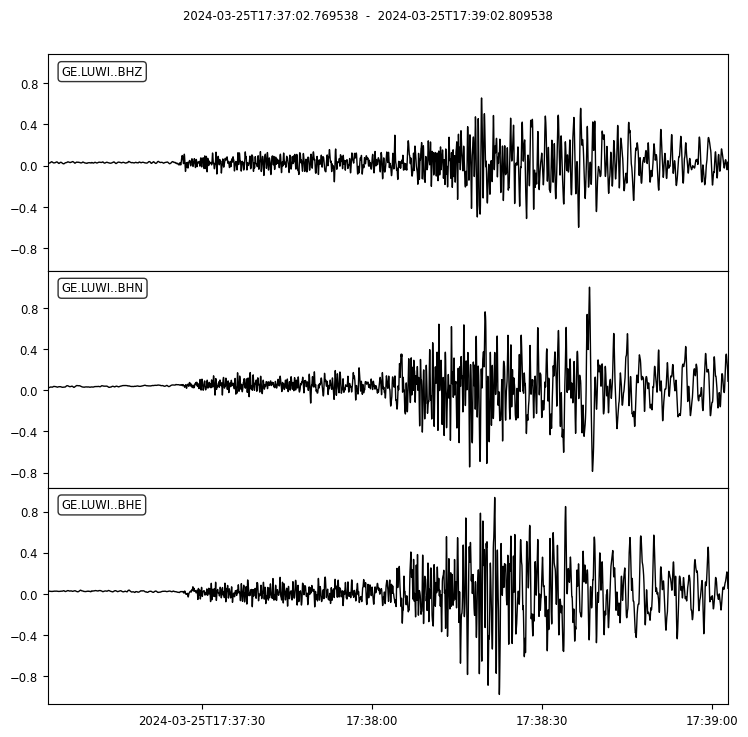

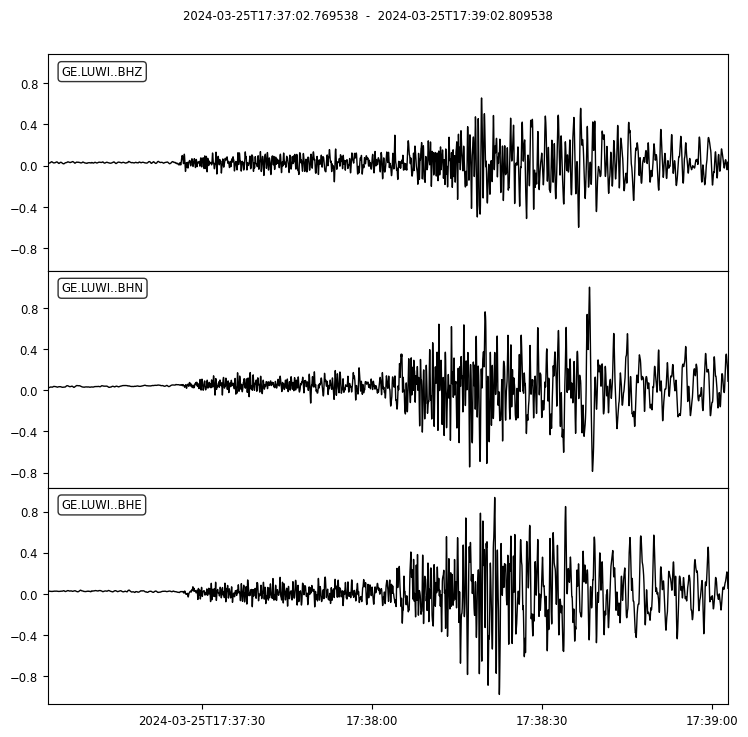

In [ ]:
combined_mid_magnitude_catalog_copy[index][3].plot()

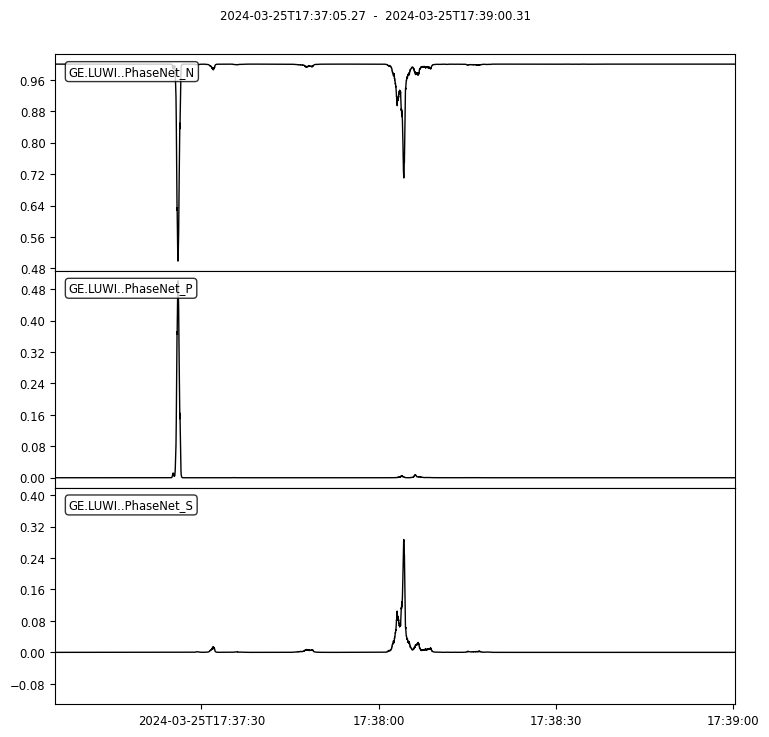

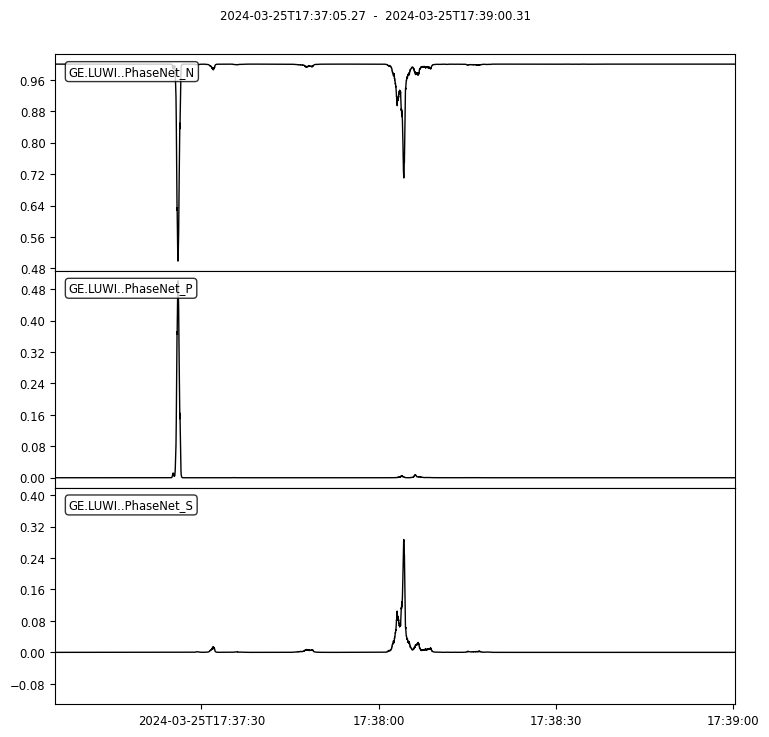

In [ ]:
phase_mid_original_catalog[index][3].plot()

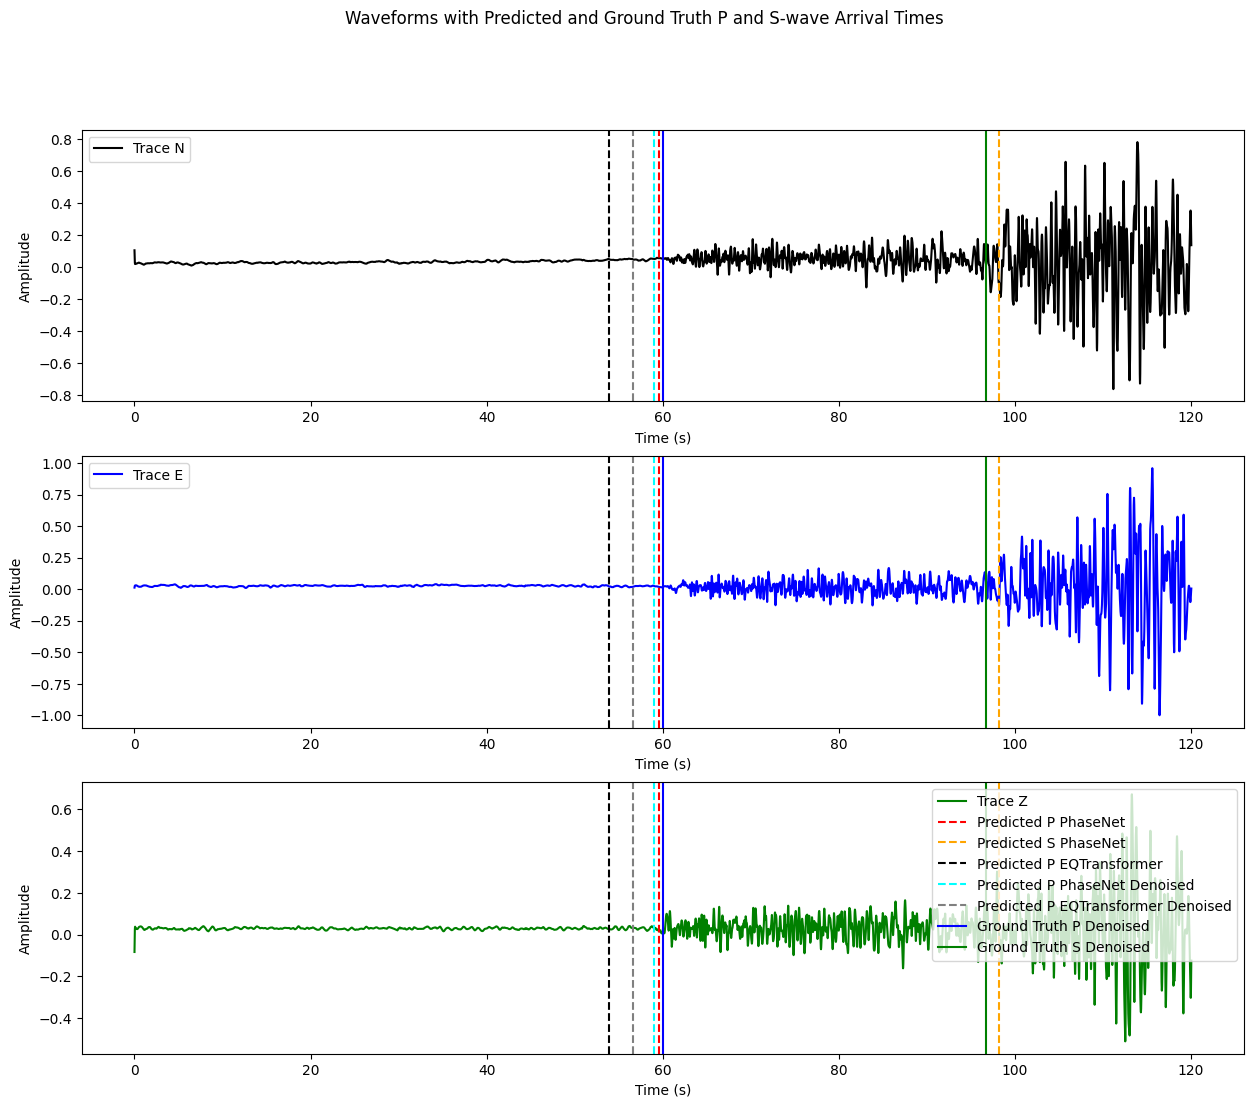

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy import read

def plot_waveform_with_p_s_arrivals(waveform, predicted_catalog, ground_truth_catalog, eq_predicted_catalog, predicted_catalog_denoised, eq_predicted_catalog_denoised):
    """
    Plots the waveform with predicted and ground truth P and S-wave arrival times.
    """
    # Plot the waveform
    fig, axs = plt.subplots(len(waveform), 1, figsize=(15, 12))

    colors = ['black', 'blue', 'green']  # Different colors for each trace
    labels = ['Trace N', 'Trace E', 'Trace Z']

    for i, trace in enumerate(waveform):
        times = np.linspace(0, trace.stats.npts / trace.stats.sampling_rate, trace.stats.npts)
        axs[i].plot(times, trace.data, color=colors[i], label=labels[i])
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Amplitude')
        axs[i].legend()

    station = predicted_catalog.picks[0].trace_id.split('.')[1]
    # Plot predicted P and S-wave arrival times
    for pick in predicted_catalog.picks:
        if pick.phase == 'P':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='red', linestyle='--', label='Predicted P PhaseNet')
        elif pick.phase == 'S':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='orange', linestyle='--', label='Predicted S PhaseNet')

    for pick in eq_predicted_catalog.picks:
        if pick.phase == 'P':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='black', linestyle='--', label='Predicted P EQTransformer')
        elif pick.phase == 'S':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='purple', linestyle='--', label='Predicted S EQTransformer')
        break
    index = 0
    for pick in predicted_catalog_denoised.picks:
        index+=1
        if index!=2:
            continue
        if pick.phase == 'P':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='cyan', linestyle='--', label='Predicted P PhaseNet Denoised')
        elif pick.phase == 'S':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='olive', linestyle='--', label='Predicted S PhaseNet Denoised')

    for pick in eq_predicted_catalog_denoised.picks:
        if pick.phase == 'P':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='grey', linestyle='--', label='Predicted P EQTransformer Denoised')
        elif pick.phase == 'S':
            for ax in axs:
                ax.axvline(x=pick.start_time - waveform[0].stats.starttime, color='navy', linestyle='--', label='Predicted S EQTransformer Denoised')
        break
    # Plot ground truth P and S-wave arrival times
    for pick in ground_truth_catalog:
        if pick['station_code'] == station:
          if 'trace_P_arrival_time' in pick:
              for ax in axs:
                  ax.axvline(x=UTCDateTime(pick['trace_P_arrival_time']) - waveform[0].stats.starttime, color='blue', linestyle='-', label='Ground Truth P Denoised')
          elif 'trace_S_arrival_time' in pick:
              for ax in axs:
                  ax.axvline(x=UTCDateTime(pick['trace_S_arrival_time']) - waveform[0].stats.starttime, color='green', linestyle='-', label='Ground Truth S Denoised')

    handles, labels = axs[2].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.suptitle('Waveforms with Predicted and Ground Truth P and S-wave Arrival Times')
    plt.show()
plot_waveform_with_p_s_arrivals(combined_mid_magnitude_catalog_copy[-3][1], phase_mid_original_classify_catalog[-3][1], tagged_mid[-3], phase_mid_eqtransformer_original_classify_catalog[-3][1],
                                phase_mid_denoised_classify_catalog[-3][1], phase_mid_eqtransformer_denoised_classify_catalog[-3][1])